# Setup

In [ ]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
%matplotlib inline
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 14, 8
RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]

# Data Loading

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/creditcard.csv")

In [ ]:
df.shape

(284807, 31)

In [ ]:
df.isnull().values.any()

np.False_

# EDA

<ipython-input-24-2107955042>:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  count_classes = pd.value_counts(df['Class'], sort = True)


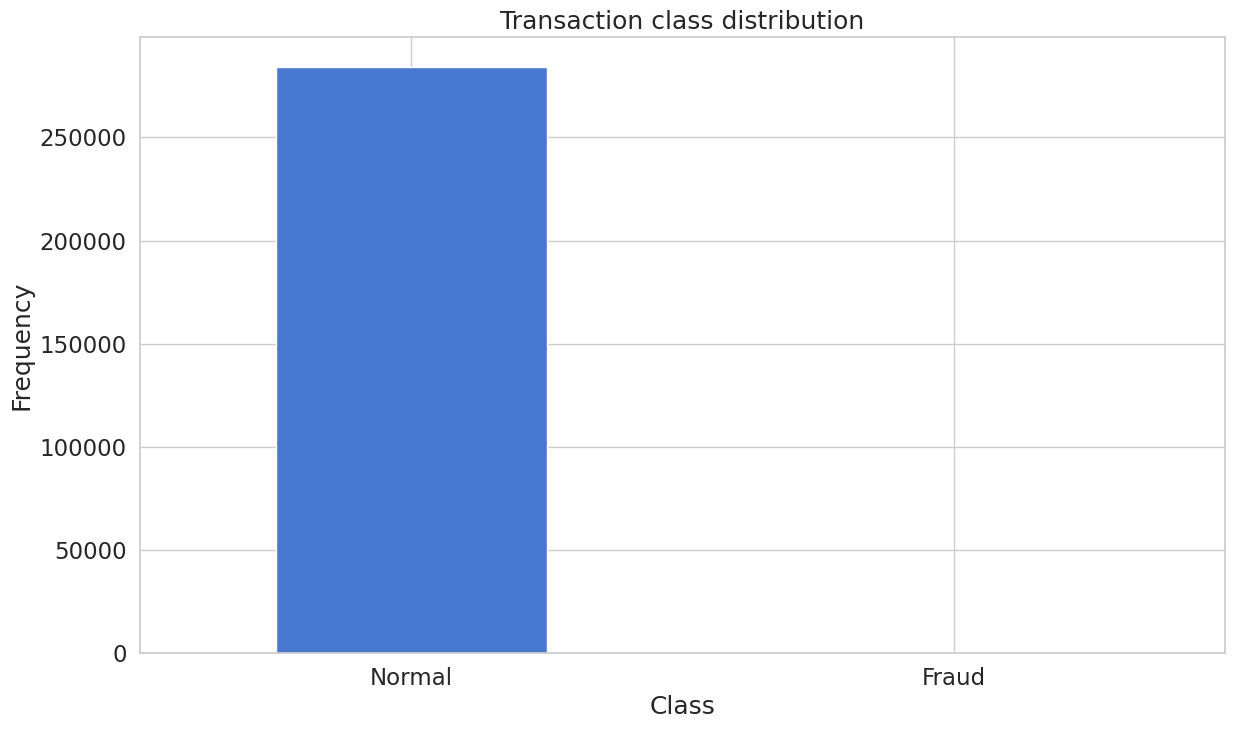

In [ ]:
count_classes = pd.value_counts(df['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Transaction class distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency");

In [ ]:
frauds = df[df.Class == 1]
normal = df[df.Class == 0]

In [ ]:
frauds.shape
normal.shape

(284315, 31)

In [ ]:
frauds.Amount.describe()

,Amount
count,492.000000
mean,122.211321
std,256.683288
min,0.000000
25%,1.000000
50%,9.250000
75%,105.890000
max,2125.870000


In [ ]:
normal.Amount.describe()

,Amount
count,284315.000000
mean,88.291022
std,250.105092
min,0.000000
25%,5.650000
50%,22.000000
75%,77.050000
max,25691.160000


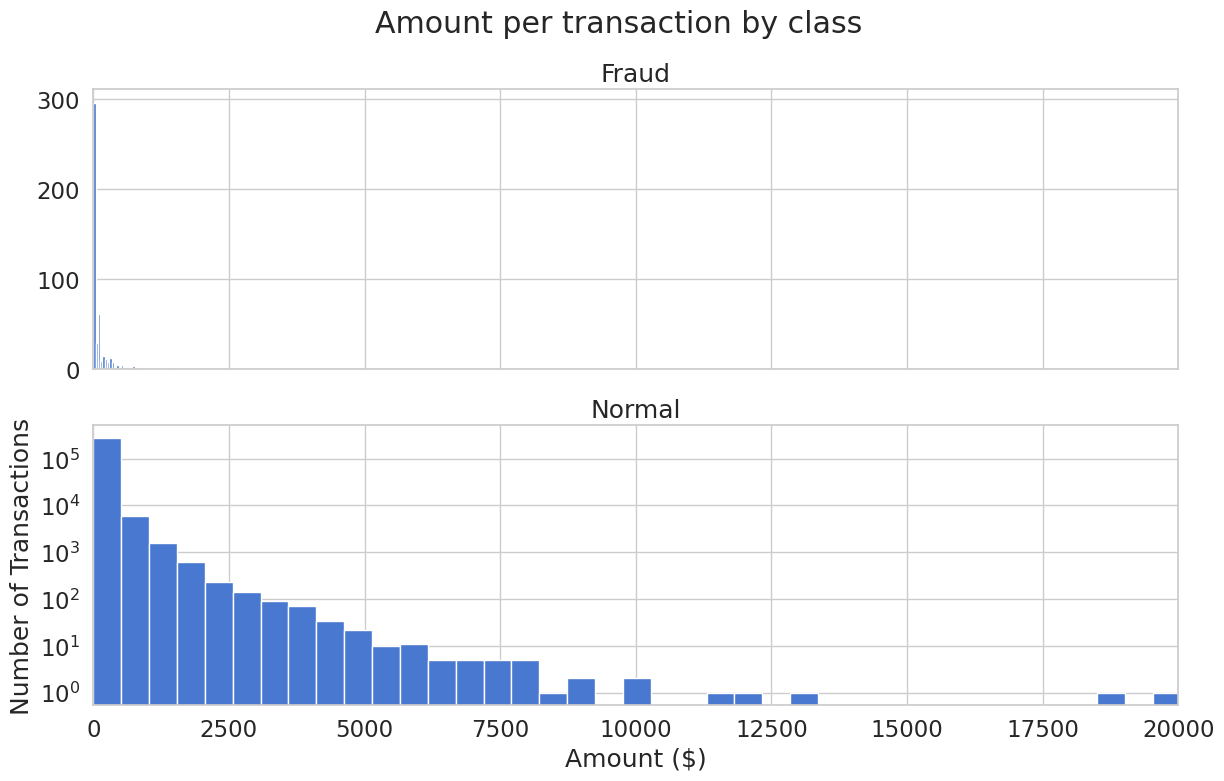

In [ ]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Amount per transaction by class')

bins = 50

ax1.hist(frauds.Amount, bins = bins)
ax1.set_title('Fraud')

ax2.hist(normal.Amount, bins = bins)
ax2.set_title('Normal')

plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.xlim((0, 20000))
plt.yscale('log')
plt.show();

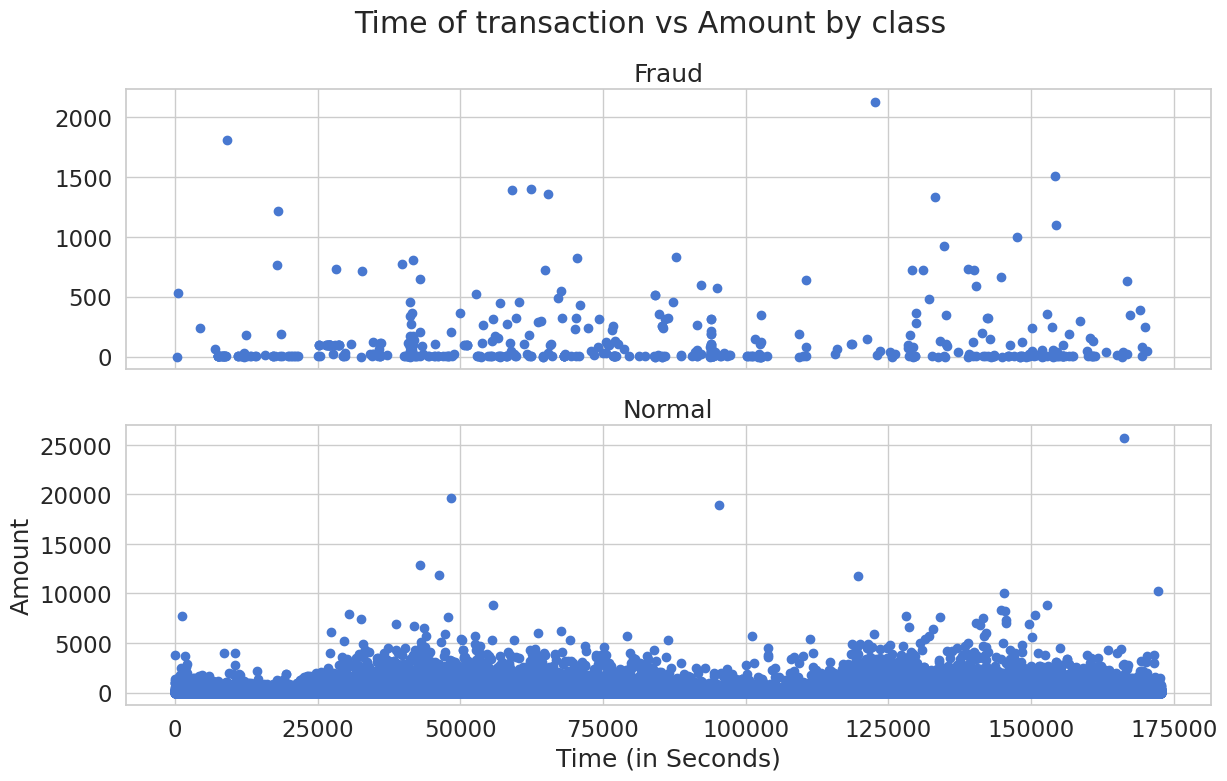

In [ ]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Time of transaction vs Amount by class')

ax1.scatter(frauds.Time, frauds.Amount)
ax1.set_title('Fraud')

ax2.scatter(normal.Time, normal.Amount)
ax2.set_title('Normal')

plt.xlabel('Time (in Seconds)')
plt.ylabel('Amount')
plt.show()

# $\color{green}{\text{Autoencoder}}$

## 데이터 전처리

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/creditcard.csv")

In [ ]:
from sklearn.preprocessing import StandardScaler

data = df.drop(['Time'], axis=1)

data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))

X_train, X_test = train_test_split(data, test_size=0.2, random_state=RANDOM_SEED)
X_train = X_train[X_train.Class == 0]
X_train = X_train.drop(['Class'], axis=1)

y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis=1)

X_train = X_train.values
X_test = X_test.values

## 모델링

Our Autoencoder uses 4 fully connected layers with 14, 7, 7 and 29 neurons respectively. The first two layers are used for our encoder, the last two go for the decoder. Additionally, L1 regularization will be used during training

In [ ]:
input_dim = X_train.shape[1]
encoding_dim = 14

In [ ]:
input_layer = Input(shape=(input_dim, ))

encoder = Dense(encoding_dim, activation="tanh",
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)

decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)

Let's train our model for 100 epochs with a batch size of 32 samples and save the best performing model to a file. The ModelCheckpoint provided by Keras is really handy for such tasks. Additionally, the training progress will be exported in a format that TensorBoard understands.

In [ ]:
# nb_epoch = 100
nb_epoch = 10
batch_size = 32

autoencoder.compile(optimizer='adam',
                    loss='mean_squared_error',
                    metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath="model.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)

history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history

Epoch 1/10
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4863 - loss: 0.8920

7108/7108 ━━━━━━━━━━━━━━━━━━━━ 32s 4ms/step - accuracy: 0.4863 - loss: 0.8920 - val_accuracy: 0.6311 - val_loss: 0.7986
Epoch 2/10
7103/7108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6379 - loss: 0.7579

7108/7108 ━━━━━━━━━━━━━━━━━━━━ 41s 4ms/step - accuracy: 0.6379 - loss: 0.7579 - val_accuracy: 0.6480 - val_loss: 0.7754
Epoch 3/10
7093/7108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6464 - loss: 0.7328

7108/7108 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - accuracy: 0.6464 - loss: 0.7329 - val_accuracy: 0.6463 - val_loss: 0.7672
Epoch 4/10
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 56s 5ms/step - accuracy: 0.6507 - loss: 0.7271 - val_accuracy: 0.6367 - val_loss: 0.7701
Epoch 5/10
7089/7108 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6568 - loss: 0.7298

7108/7108 ━━━━━━━━━━━━━━━━━━━━ 34s 4ms/step - accuracy: 0.6568 - loss: 0.7298 - val_accuracy: 0.6575 - val_loss: 0.7589
Epoch 6/10
7085/7108 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6590 - loss: 0.7581

7108/7108 ━━━━━━━━━━━━━━━━━━━━ 31s 4ms/step - accuracy: 0.6590 - loss: 0.7580 - val_accuracy: 0.6571 - val_loss: 0.7569
Epoch 7/10
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 39s 4ms/step - accuracy: 0.6595 - loss: 0.7206 - val_accuracy: 0.6576 - val_loss: 0.7586
Epoch 8/10
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 53s 6ms/step - accuracy: 0.6625 - loss: 0.7156 - val_accuracy: 0.6641 - val_loss: 0.7593
Epoch 9/10
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 75s 5ms/step - accuracy: 0.6658 - loss: 0.7184 - val_accuracy: 0.6603 - val_loss: 0.7576
Epoch 10/10
7095/7108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6657 - loss: 0.7354

7108/7108 ━━━━━━━━━━━━━━━━━━━━ 29s 3ms/step - accuracy: 0.6657 - loss: 0.7354 - val_accuracy: 0.6694 - val_loss: 0.7538


In [ ]:
autoencoder = load_model('model.h5')

## 모델 평가 (1)

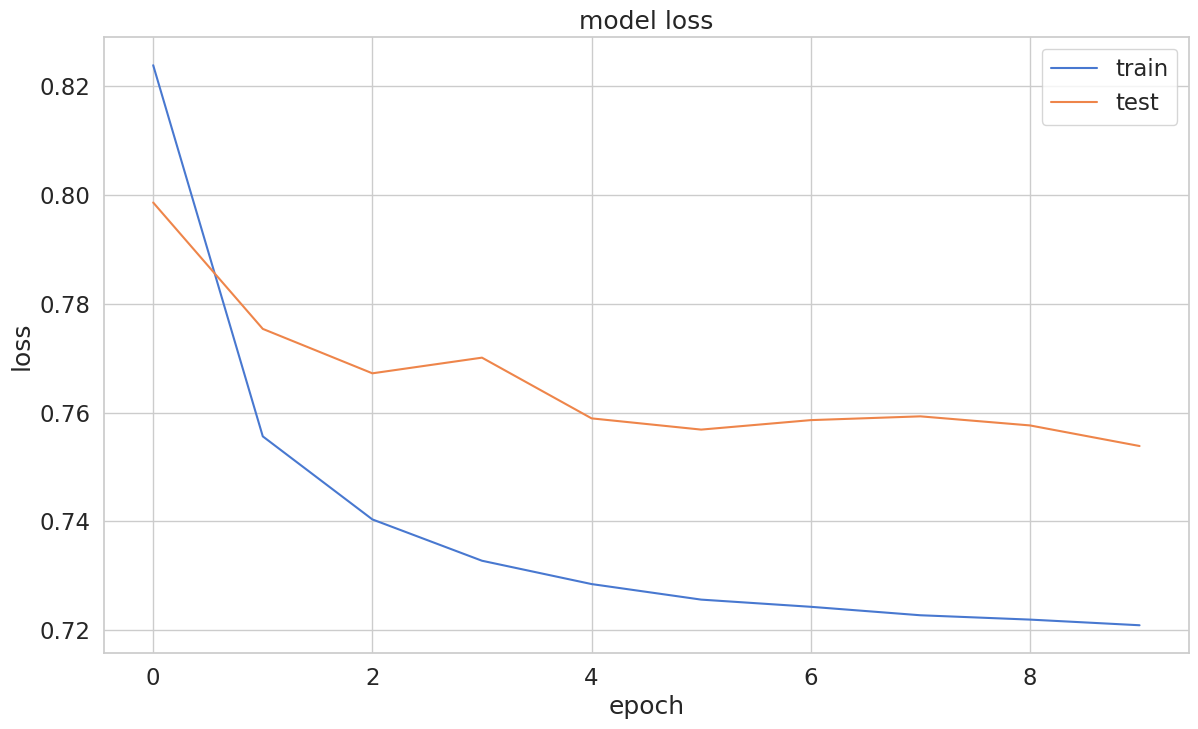

In [ ]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

In [ ]:
predictions = autoencoder.predict(X_test)

1781/1781 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


In [ ]:
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})

In [ ]:
error_df.describe()

,reconstruction_error,true_class
count,56962.000000,56962.000000
mean,0.747976,0.001720
std,3.474021,0.041443
min,0.066951,0.000000
25%,0.252127,0.000000
50%,0.393975,0.000000
75%,0.617469,0.000000
max,274.422482,1.000000


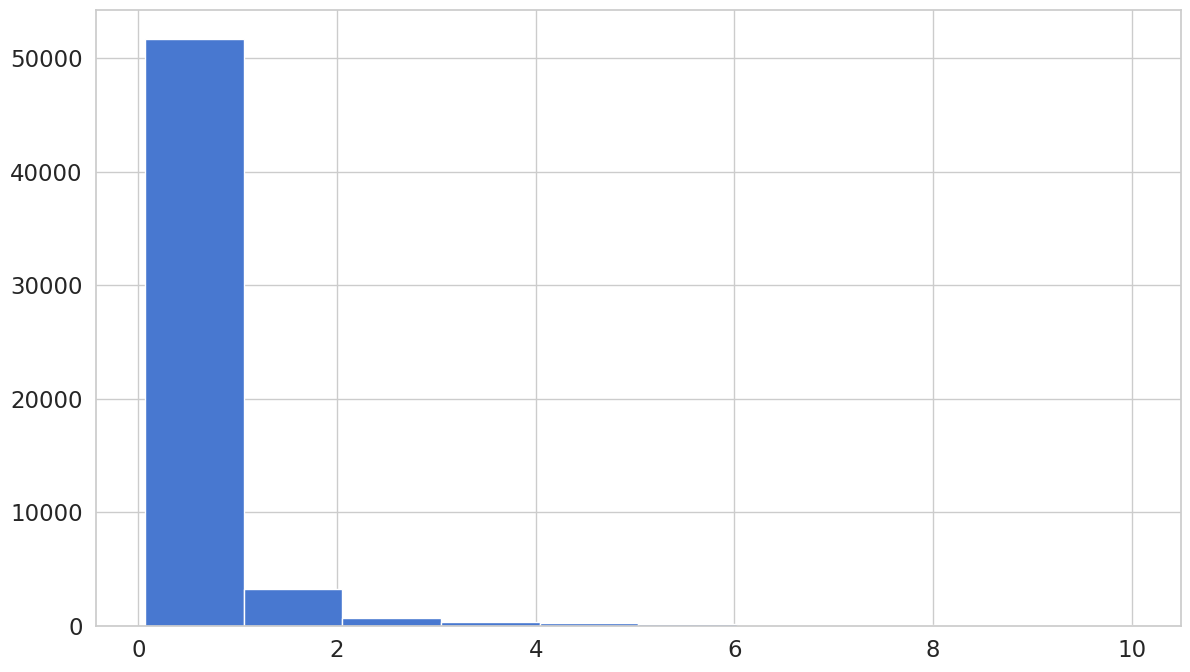

In [ ]:
# Reconstruction error without fraud
fig = plt.figure()
ax = fig.add_subplot(111)
normal_error_df = error_df[(error_df['true_class']== 0) & (error_df['reconstruction_error'] < 10)]
_ = ax.hist(normal_error_df.reconstruction_error.values, bins=10)

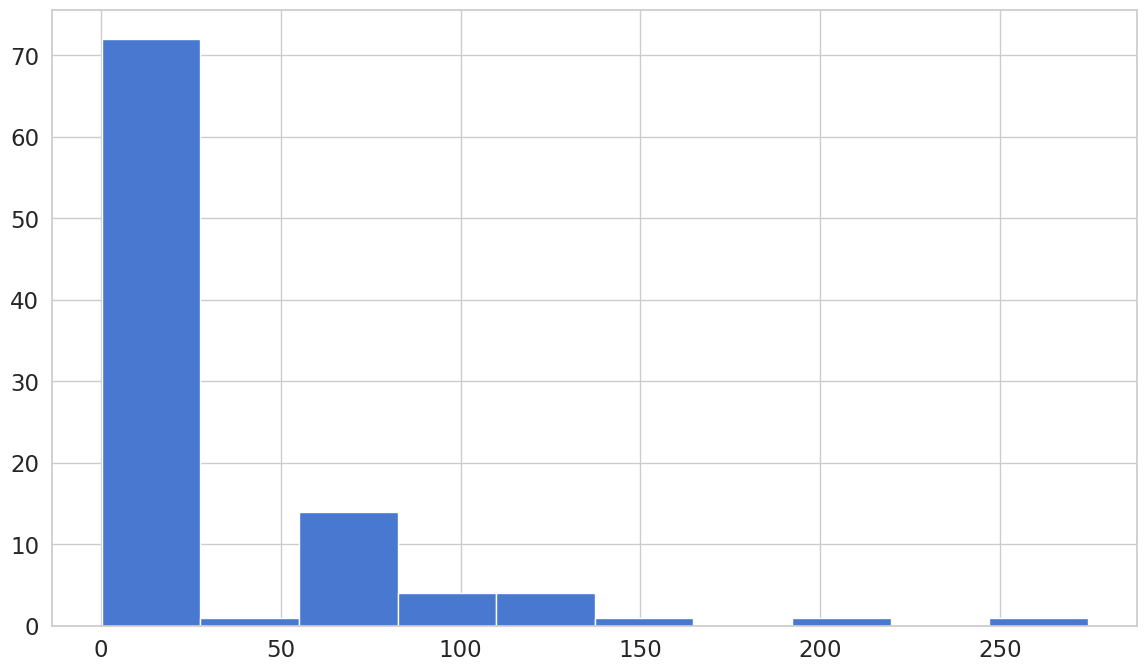

In [ ]:
# Reconstruction error with fraud
fig = plt.figure()
ax = fig.add_subplot(111)
fraud_error_df = error_df[error_df['true_class'] == 1]
_ = ax.hist(fraud_error_df.reconstruction_error.values, bins=10)

In [ ]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

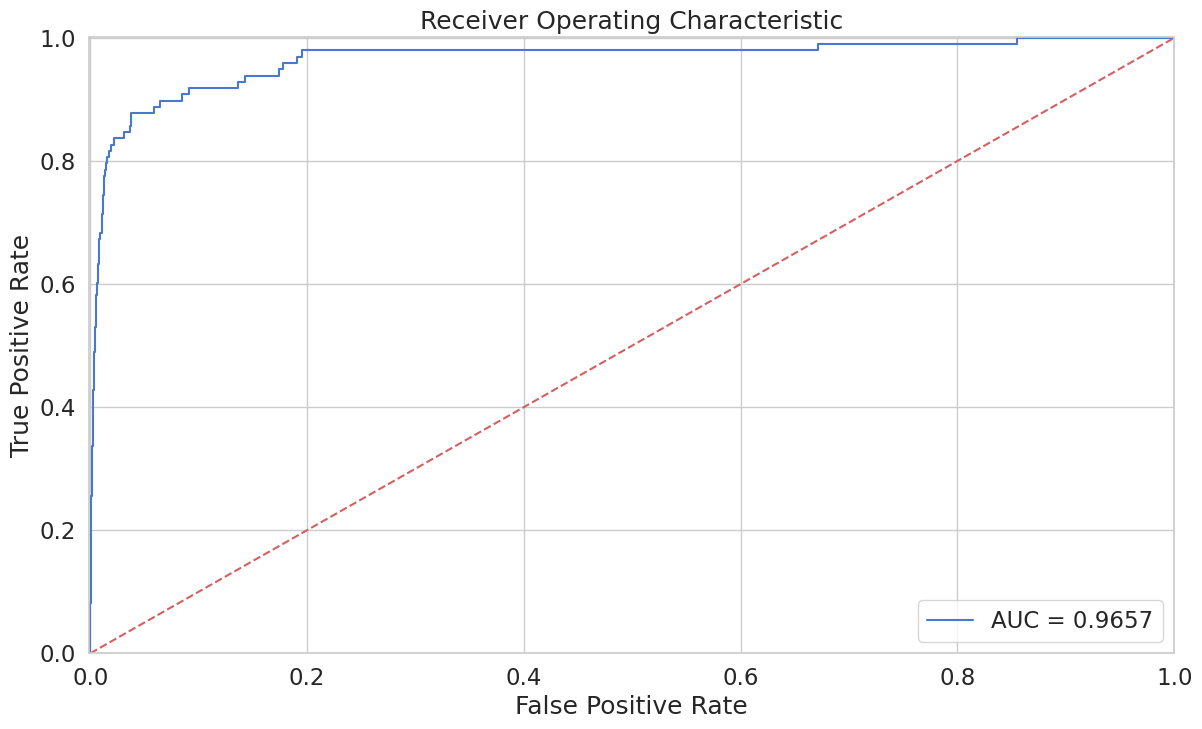

In [ ]:
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

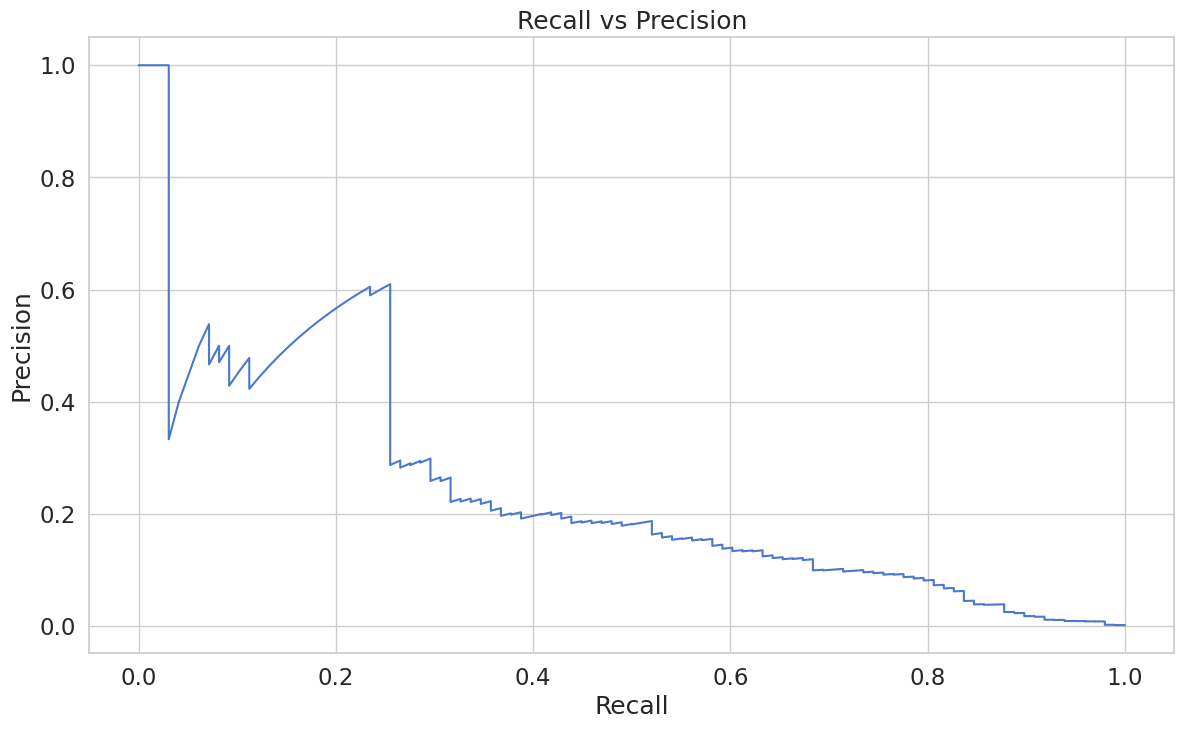

In [ ]:
precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

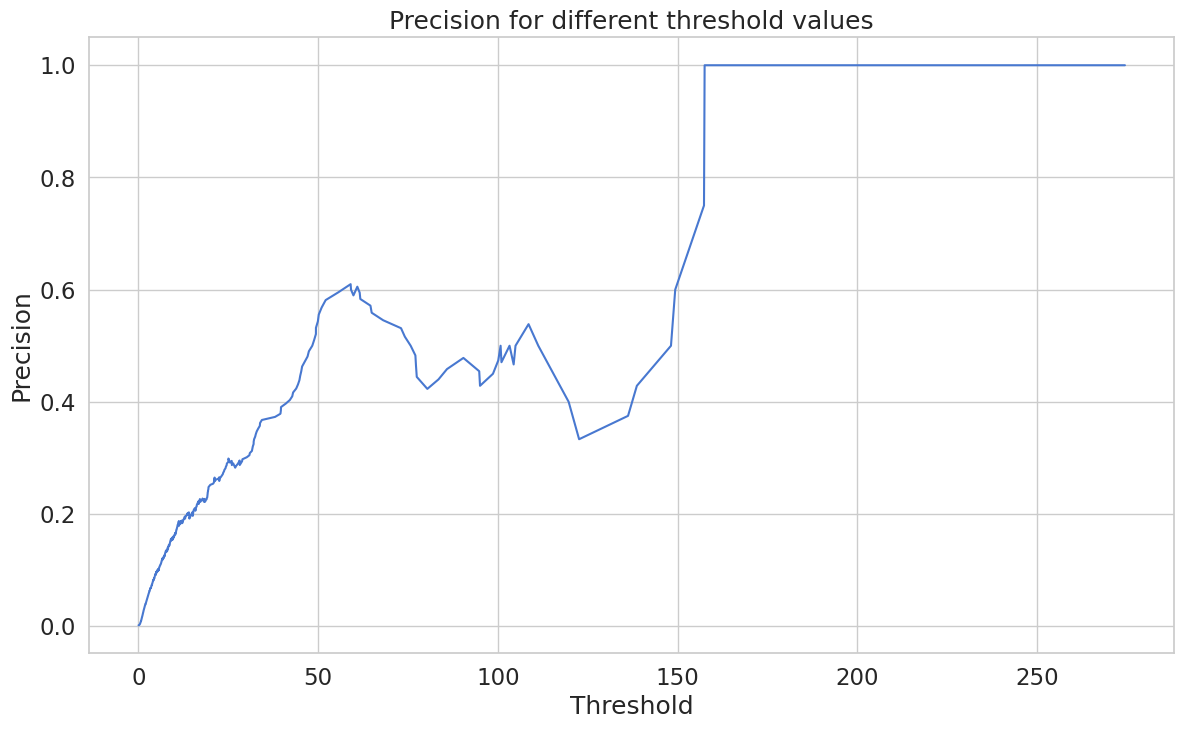

In [ ]:
plt.plot(th, precision[1:], 'b', label='Threshold-Precision curve')
plt.title('Precision for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.show()

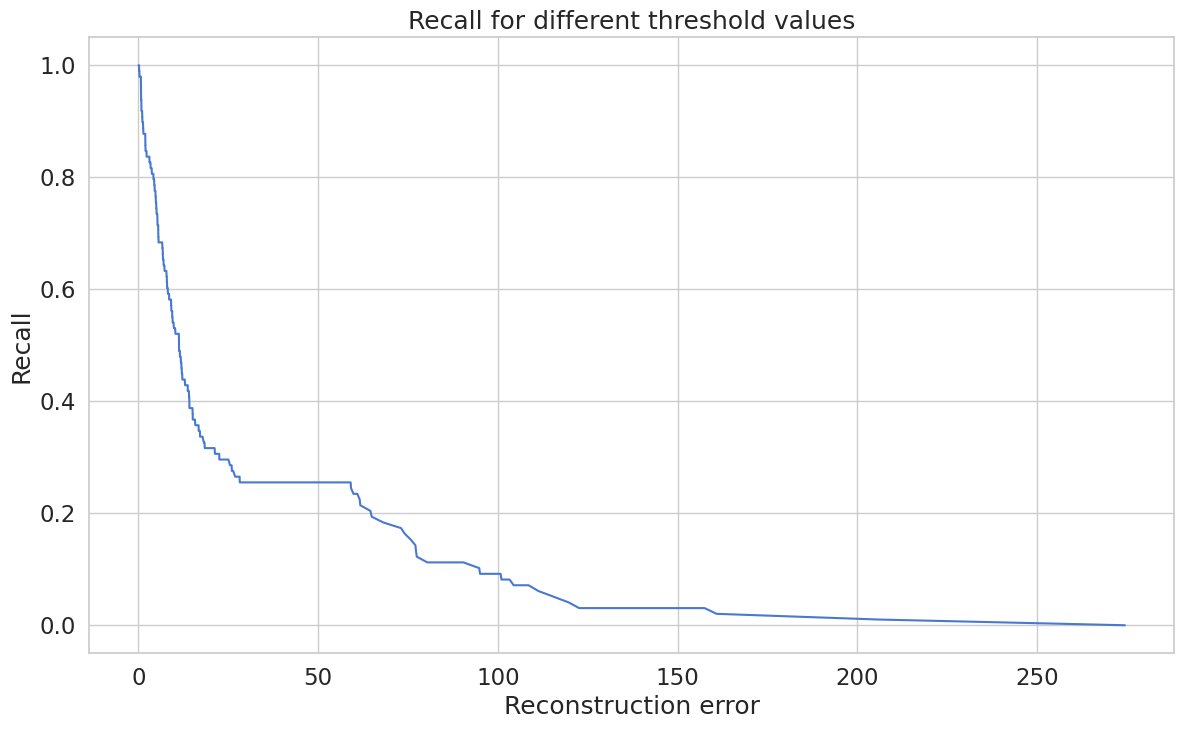

In [ ]:
plt.plot(th, recall[1:], 'b', label='Threshold-Recall curve')
plt.title('Recall for different threshold values')
plt.xlabel('Reconstruction error')
plt.ylabel('Recall')
plt.show()

In [ ]:
threshold = 2.9

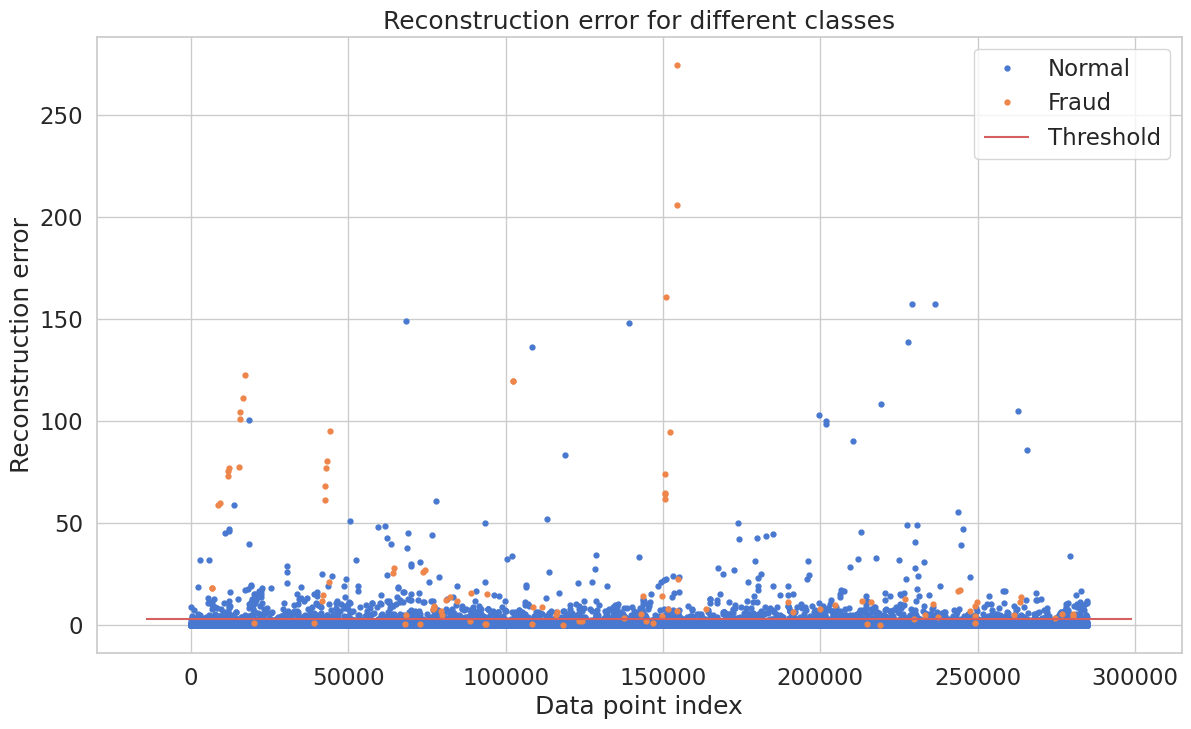

In [ ]:
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show()

## 모델 평가 (2)

,Metric,Score
0,Accuracy,0.9766
1,Precision,0.0585
2,Recall,0.8367
3,F1 Score,0.1094


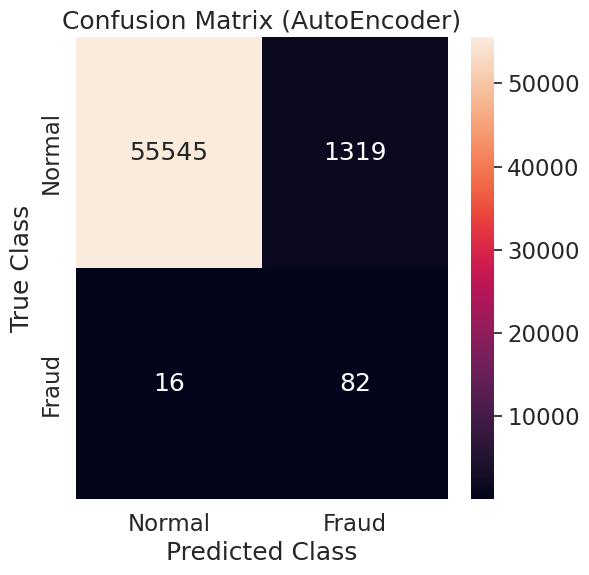

In [ ]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
)
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

y_true = error_df['true_class']
y_pred = [1 if e > 2.9 else 0 for e in error_df['reconstruction_error']]

metrics_dict = {
    "Accuracy": accuracy_score(y_true, y_pred),
    "Precision": precision_score(y_true, y_pred),
    "Recall": recall_score(y_true, y_pred),
    "F1 Score": f1_score(y_true, y_pred)
}
df_metrics = pd.DataFrame(metrics_dict.items(), columns=["Metric", "Score"]).round(4)

from IPython.display import display
display(df_metrics)

LABELS = ["Normal", "Fraud"]
conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", xticklabels=LABELS, yticklabels=LABELS)
plt.title("Confusion Matrix (AutoEncoder)")
plt.ylabel("True Class")
plt.xlabel("Predicted Class")
plt.show()

# $\color{green}{\text{Random Forest}}$

## 전처리

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/creditcard.csv")

In [ ]:
from sklearn.preprocessing import StandardScaler

data = df.drop(['Time'], axis=1)

data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))

X_train, X_test = train_test_split(data, test_size=0.2, random_state=RANDOM_SEED)
X_train = X_train[X_train.Class == 0]
X_train = X_train.drop(['Class'], axis=1)

y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis=1)

X_train = X_train.values
X_test = X_test.values

## 모델링

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# 피처와 타깃 분리
X = data.drop(['Class'], axis=1)
y = data['Class']

# 학습/테스트 분리 (AutoEncoder와 동일하게 80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 모델 정의 및 학습
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, class_weight='balanced')
rf_clf.fit(X_train, y_train)

# 예측
y_pred = rf_clf.predict(X_test)

## 평가

,Metric,Score
0,Accuracy,0.9995
1,Precision,0.9610
2,Recall,0.7551
3,F1 Score,0.8457


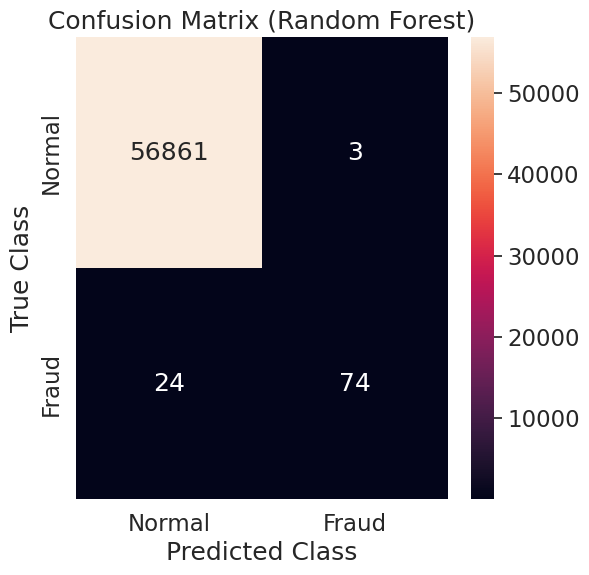

In [ ]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 평가지표 정리
metrics_dict = {
    "Accuracy": accuracy_score(y_test, y_pred),
    "Precision": precision_score(y_test, y_pred),
    "Recall": recall_score(y_test, y_pred),
    "F1 Score": f1_score(y_test, y_pred)
}
df_metrics = pd.DataFrame(metrics_dict.items(), columns=["Metric", "Score"]).round(4)

# 출력
from IPython.display import display
display(df_metrics)

# 혼동행렬 계산
conf_matrix = confusion_matrix(y_test, y_pred)

# 시각화
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", xticklabels=LABELS, yticklabels=LABELS)

plt.title("Confusion Matrix (Random Forest)")
plt.ylabel("True Class")
plt.xlabel("Predicted Class")
plt.show()

# $\color{green}{\text{XGBoost}}$

## 전처리

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/creditcard.csv")

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# 데이터 로드 및 전처리
df = pd.read_csv("/content/drive/MyDrive/creditcard.csv")
df = df.drop(['Time'], axis=1)
df['Amount'] = StandardScaler().fit_transform(df['Amount'].values.reshape(-1, 1))

# 피처와 타깃 분리
X = df.drop('Class', axis=1)
y = df['Class']

# 학습/검증 분할
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

## 모델링

In [ ]:
from xgboost import XGBClassifier

# 모델 정의 및 학습
xgb_clf = XGBClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum(),  # 클래스 불균형 보정
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss',
    n_jobs=-1
)
xgb_clf.fit(X_train, y_train)

# 예측
y_pred = xgb_clf.predict(X_test)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:35:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


## 평가

,Metric,Score
0,Accuracy,0.9995
1,Precision,0.9610
2,Recall,0.7551
3,F1 Score,0.8457


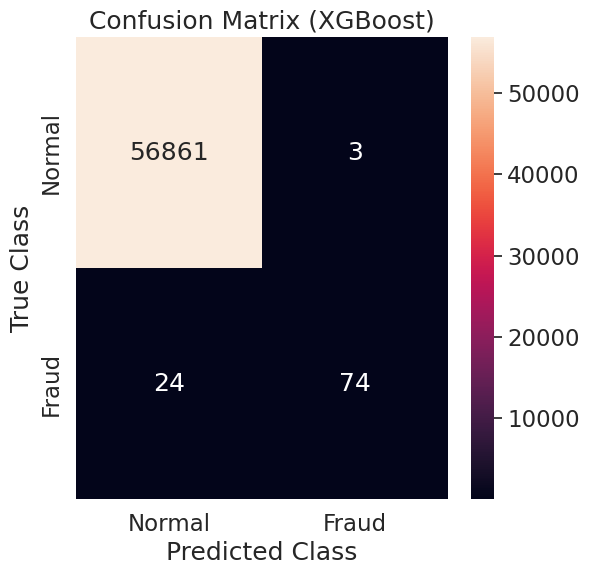

In [ ]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 평가지표 정리
metrics_dict = {
    "Accuracy": accuracy_score(y_test, y_pred),
    "Precision": precision_score(y_test, y_pred),
    "Recall": recall_score(y_test, y_pred),
    "F1 Score": f1_score(y_test, y_pred)
}
df_metrics = pd.DataFrame(metrics_dict.items(), columns=["Metric", "Score"]).round(4)

# 출력
from IPython.display import display
display(df_metrics)

# 혼동행렬 시각화
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", xticklabels=LABELS, yticklabels=LABELS)

plt.title("Confusion Matrix (XGBoost)")
plt.ylabel("True Class")
plt.xlabel("Predicted Class")
plt.show()

# $\color{green}{\text{GRU}}$

## 전처리

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/creditcard.csv")

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# 전처리
df = df.drop(['Time'], axis=1)
df['Amount'] = StandardScaler().fit_transform(df['Amount'].values.reshape(-1, 1))

# 피처와 타깃 분리
X = df.drop('Class', axis=1).values
y = df['Class'].values

# RNN 입력 형식: (samples, timesteps=1, features)
X = X.reshape((X.shape[0], 1, X.shape[1]))

# 학습/검증 분할
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

## 모델링

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.callbacks import EarlyStopping

# GRU 모델 구성
model = Sequential([
    GRU(32, input_shape=(1, X.shape[2]), return_sequences=False),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 학습
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=512,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


357/357 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.8942 - loss: 0.3000 - val_accuracy: 0.9994 - val_loss: 0.0054
Epoch 2/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9993 - loss: 0.0045 - val_accuracy: 0.9994 - val_loss: 0.0034
Epoch 3/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9994 - loss: 0.0031 - val_accuracy: 0.9994 - val_loss: 0.0030
Epoch 4/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9995 - loss: 0.0026 - val_accuracy: 0.9994 - val_loss: 0.0029
Epoch 5/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9995 - loss: 0.0025 - val_accuracy: 0.9994 - val_loss: 0.0029
Epoch 6/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9994 - loss: 0.0024 - val_accuracy: 0.9995 - val_loss: 0.0028
Epoch 7/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9995 - loss: 0.0023 - val_accuracy: 0.9995 - val_loss: 0.0027
Epoch 8/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9995 - loss: 0.0022 - val_accuracy: 0.9995 - val

## 평가

1781/1781 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


,Metric,Score
0,Accuracy,0.9994
1,Precision,0.8387
2,Recall,0.7959
3,F1 Score,0.8168


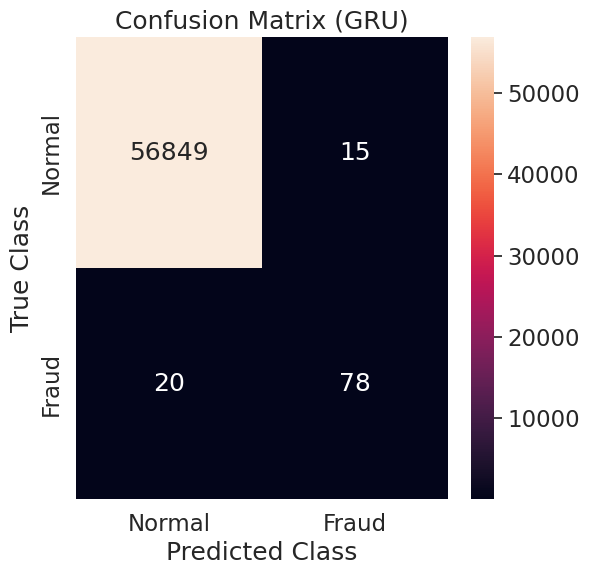

In [ ]:
# 예측
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int).reshape(-1)

# 평가지표 계산
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import pandas as pd

metrics_dict = {
    "Accuracy": accuracy_score(y_test, y_pred),
    "Precision": precision_score(y_test, y_pred),
    "Recall": recall_score(y_test, y_pred),
    "F1 Score": f1_score(y_test, y_pred)
}
df_metrics = pd.DataFrame(metrics_dict.items(), columns=["Metric", "Score"]).round(4)

from IPython.display import display
display(df_metrics)

# Confusion matrix 시각화
import matplotlib.pyplot as plt
import seaborn as sns

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", xticklabels=LABELS, yticklabels=LABELS)
plt.title("Confusion Matrix (GRU)")
plt.ylabel("True Class")
plt.xlabel("Predicted Class")
plt.show()

# $\color{green}{\text{PatchTST}}$

## 전처리

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/creditcard.csv")

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# 데이터 로드 및 정규화
df = df.drop(['Time'], axis=1)
df['Amount'] = StandardScaler().fit_transform(df['Amount'].values.reshape(-1, 1))

# 피처와 타깃 분리
X = df.drop('Class', axis=1).values
y = df['Class'].values

# Patch 형식으로 reshape: (samples, 1, features)
import numpy as np
X = X.reshape((X.shape[0], 1, X.shape[1]))

# 학습/테스트 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

## 모델링

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim

# PatchTST 정의
class PatchTST(nn.Module):
    def __init__(self, input_size, patch_len=1, d_model=64, n_heads=4, e_layers=2):
        super(PatchTST, self).__init__()
        self.proj = nn.Linear(input_size, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=n_heads, dim_feedforward=128)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=e_layers)
        self.head = nn.Sequential(
            nn.Flatten(),
            nn.Linear(d_model, 1),
            nn.Sigmoid()
        )

    def forward(self, x):  # x: [B, 1, F]
        x = self.proj(x)         # [B, 1, d_model]
        x = self.encoder(x)      # [B, 1, d_model]
        out = self.head(x)       # [B, 1]
        return out.squeeze(-1)   # [B]

# 학습 준비
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32))

train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=512)

# 모델 생성 및 옵티마이저 정의
model = PatchTST(input_size=X.shape[2]).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# 학습
for epoch in range(5):
    model.train()
    epoch_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        out = model(xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f"Epoch {epoch+1} - Loss: {epoch_loss:.4f}")

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1 - Loss: 5.7044
Epoch 2 - Loss: 1.4842
Epoch 3 - Loss: 1.3272
Epoch 4 - Loss: 1.2536
Epoch 5 - Loss: 1.2373


## 평가

,Metric,Score
0,Accuracy,0.9993
1,Precision,0.7864
2,Recall,0.8265
3,F1 Score,0.8060


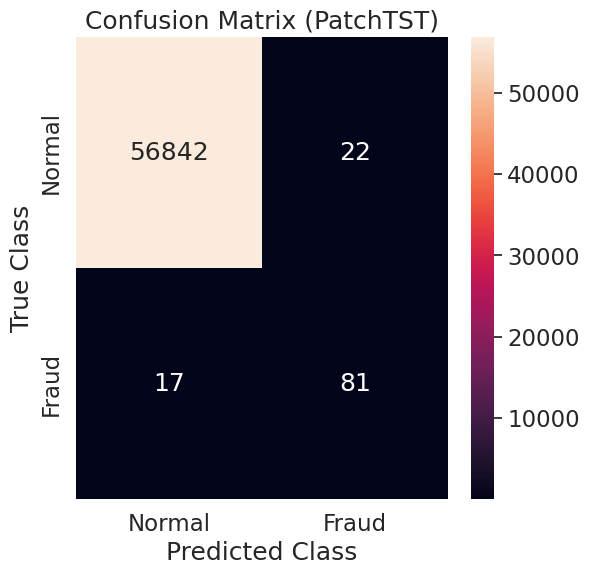

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 예측
model.eval()
y_probs, y_trues = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        probs = model(xb).cpu().numpy()
        y_probs.extend(probs)
        y_trues.extend(yb.numpy())

y_pred = (np.array(y_probs) > 0.5).astype(int)
y_true = np.array(y_trues)

# 평가지표 출력
metrics = {
    "Accuracy": accuracy_score(y_true, y_pred),
    "Precision": precision_score(y_true, y_pred),
    "Recall": recall_score(y_true, y_pred),
    "F1 Score": f1_score(y_true, y_pred)
}
import pandas as pd
df_metrics = pd.DataFrame(metrics.items(), columns=["Metric", "Score"]).round(4)

from IPython.display import display
display(df_metrics)

# 혼동행렬 시각화
LABELS = ["Normal", "Fraud"]
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", xticklabels=LABELS, yticklabels=LABELS)
plt.title("Confusion Matrix (PatchTST)")
plt.ylabel("True Class")
plt.xlabel("Predicted Class")
plt.show()

# $\color{green}{\text{Hybrid Model}}$

**AutoEncoder → Latent Feature 추출 → XGBoost & Random Forest → Soft Voting Ensemble**

## 전처리

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/creditcard.csv")

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# 데이터 로드 및 정규화
df = df.drop(['Time'], axis=1)
df['Amount'] = StandardScaler().fit_transform(df['Amount'].values.reshape(-1, 1))

# 피처와 타깃 분리
X = df.drop('Class', axis=1).values
y = df['Class'].values

# 학습/검증 분할
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

## AutoEncoder 정의 및 Latent Feature 추출

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam

# AutoEncoder 구성
input_dim = X_train_raw.shape[1]
input_layer = Input(shape=(input_dim,))
encoded = Dense(32, activation='relu')(input_layer)
latent = Dense(16, activation='relu')(encoded)
decoded = Dense(32, activation='relu')(latent)
output_layer = Dense(input_dim, activation='linear')(decoded)

autoencoder = Model(inputs=input_layer, outputs=output_layer)
autoencoder.compile(optimizer=Adam(), loss='mse')
autoencoder.fit(X_train_raw, X_train_raw, epochs=10, batch_size=256, validation_split=0.2, verbose=0)

# Encoder 모델 정의
encoder = Model(inputs=input_layer, outputs=latent)

# Latent feature 추출
X_train_latent = encoder.predict(X_train_raw)
X_test_latent = encoder.predict(X_test_raw)

7121/7121 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
1781/1781 ━━━━━━━━━━━━━━━━━━━━ 2s 981us/step


## XGBoost & Random Forest 학습

In [ ]:
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

# 클래스 비율 보정
scale_pos = (y_train == 0).sum() / (y_train == 1).sum()

# XGBoost
xgb = XGBClassifier(n_estimators=100, scale_pos_weight=scale_pos,
                    use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(X_train_latent, y_train)

# Random Forest
rf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
rf.fit(X_train_latent, y_train)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [21:04:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


RandomForestClassifier(class_weight='balanced', random_state=42)

## Soft Voting Ensemble 예측

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# 각 모델의 확률 예측
xgb_prob = xgb.predict_proba(X_test_latent)[:, 1]
rf_prob = rf.predict_proba(X_test_latent)[:, 1]

# Soft voting (단순 평균)
ensemble_prob = (xgb_prob + rf_prob) / 2
y_pred = (ensemble_prob > 0.5).astype(int)

## 평가

,Metric,Score
0,Accuracy,0.9995
1,Precision,0.8750
2,Recall,0.8571
3,F1 Score,0.8660


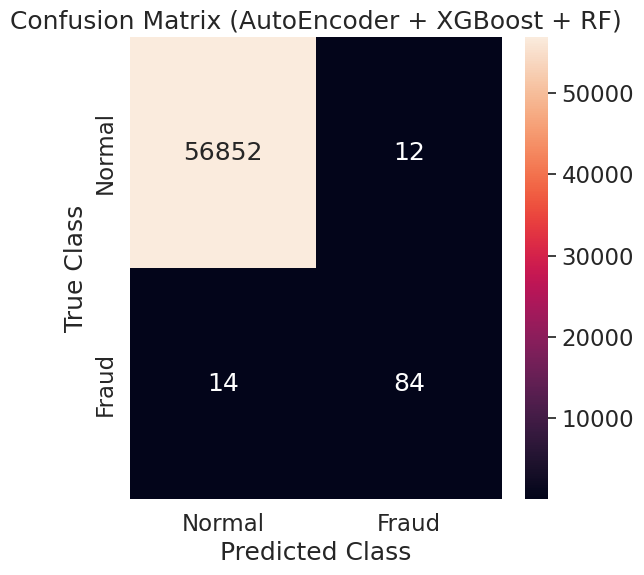

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

metrics_dict = {
    "Accuracy": accuracy_score(y_test, y_pred),
    "Precision": precision_score(y_test, y_pred),
    "Recall": recall_score(y_test, y_pred),
    "F1 Score": f1_score(y_test, y_pred)
}
import pandas as pd
df_metrics = pd.DataFrame(metrics_dict.items(), columns=["Metric", "Score"]).round(4)

from IPython.display import display
display(df_metrics)

LABELS = ["Normal", "Fraud"]
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", xticklabels=LABELS, yticklabels=LABELS)
plt.title("Confusion Matrix (AutoEncoder + XGBoost + RF)")
plt.ylabel("True Class")
plt.xlabel("Predicted Class")
plt.show()

# $\color{green}{\text{Hybrid Mode (2)}}$

**AutoEncoder → Latent Feature 추출 → XGBoost & Random Forest → Meta Classifier (Logistic Regression)**

## 전처리

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/creditcard.csv")

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

df = df.drop(['Time'], axis=1)
df['Amount'] = StandardScaler().fit_transform(df['Amount'].values.reshape(-1, 1))

X = df.drop('Class', axis=1).values
y = df['Class'].values
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

## AutoEncoder 정의 및 Latent Feature 추출

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam

input_dim = X_train_raw.shape[1]
input_layer = Input(shape=(input_dim,))
encoded = Dense(32, activation='relu')(input_layer)
latent = Dense(16, activation='relu')(encoded)
decoded = Dense(32, activation='relu')(latent)
output_layer = Dense(input_dim, activation='linear')(decoded)

autoencoder = Model(inputs=input_layer, outputs=output_layer)
autoencoder.compile(optimizer=Adam(), loss='mse')
autoencoder.fit(X_train_raw, X_train_raw, epochs=10, batch_size=256, validation_split=0.2, verbose=0)

encoder = Model(inputs=input_layer, outputs=latent)
X_train_latent = encoder.predict(X_train_raw)
X_test_latent = encoder.predict(X_test_raw)

7121/7121 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
1781/1781 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


## Base Learners: XGBoost, Random Forest

In [ ]:
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

scale_pos = (y_train == 0).sum() / (y_train == 1).sum()

xgb = XGBClassifier(n_estimators=100, scale_pos_weight=scale_pos,
                    use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(X_train_latent, y_train)

rf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
rf.fit(X_train_latent, y_train)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [21:11:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


RandomForestClassifier(class_weight='balanced', random_state=42)

## Base 모델 예측 결과 (meta feature 생성용)

In [ ]:
xgb_train_pred = xgb.predict_proba(X_train_latent)[:, 1]
rf_train_pred = rf.predict_proba(X_train_latent)[:, 1]

xgb_test_pred = xgb.predict_proba(X_test_latent)[:, 1]
rf_test_pred = rf.predict_proba(X_test_latent)[:, 1]

meta_X_train = pd.DataFrame({'xgb': xgb_train_pred, 'rf': rf_train_pred})
meta_X_test = pd.DataFrame({'xgb': xgb_test_pred, 'rf': rf_test_pred})

## Meta Learner: Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

meta_clf = LogisticRegression()
meta_clf.fit(meta_X_train, y_train)

y_pred = meta_clf.predict(meta_X_test)

## 평가


,Metric,Score
0,Accuracy,0.9995
1,Precision,0.8913
2,Recall,0.8367
3,F1 Score,0.8632


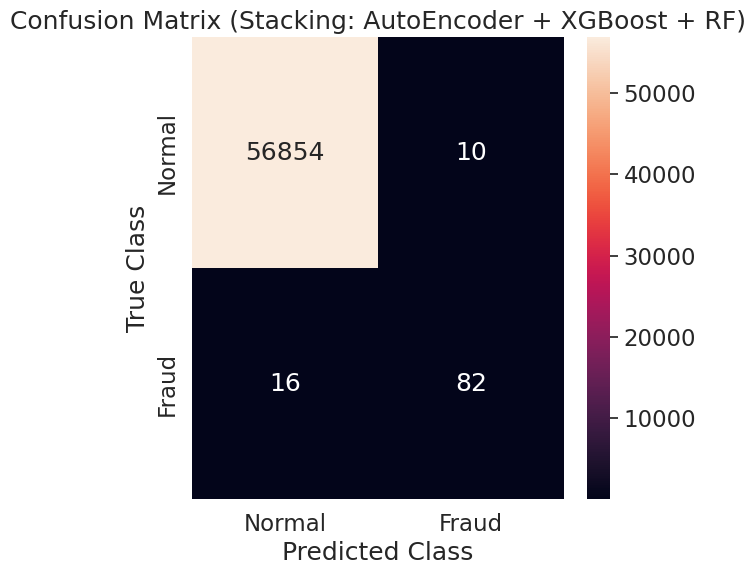

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

metrics_dict = {
    "Accuracy": accuracy_score(y_test, y_pred),
    "Precision": precision_score(y_test, y_pred),
    "Recall": recall_score(y_test, y_pred),
    "F1 Score": f1_score(y_test, y_pred)
}
import pandas as pd
df_metrics = pd.DataFrame(metrics_dict.items(), columns=["Metric", "Score"]).round(4)

from IPython.display import display
display(df_metrics)

LABELS = ["Normal", "Fraud"]
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", xticklabels=LABELS, yticklabels=LABELS)
plt.title("Confusion Matrix (Stacking: AutoEncoder + XGBoost + RF)")
plt.ylabel("True Class")
plt.xlabel("Predicted Class")
plt.show()

# Conclusion

---

### 모델별 이상 탐지 성능 정리

| Model             | Accuracy | Precision | Recall | F1 Score |
|------------------|----------|-----------|--------|----------|
| Autoencoder       | 0.9766   | 0.0585    | 0.8367 | 0.1094   |
| Random Forest     | 0.9995   | 0.9610    | 0.7551 | 0.8457   |
| XGBoost           | 0.9995   | 0.9610    | 0.7551 | 0.8457   |
| GRU               | 0.9994   | 0.8387    | 0.7959 | 0.8168   |
| PatchTST          | 0.9993   | 0.7864    | 0.8265 | 0.8060   |
| Hybrid Model      | 0.9995   | 0.8750    | 0.8571 | 0.8660   |
| Hybrid Model (2)  | 0.9995   | 0.8913    | 0.8367 | 0.8632   |

---

### 1. Recall 우선 (False Negative 최소화) → 실제 사기 거래를 놓치지 않는 게 중요할 때

- 의미: 실제 사기(Fraud)를 얼마나 잘 잡았는가
- 우선 적용 시점:
    - 금융 사기, 보험 사기 등에서 사기 하나라도 놓치면 큰 손해가 발생할 경우
    - 규제 준수 필요 상황
- 추천 모델:
    - Autoencoder (Recall 0.8367)
    - Hybrid Model (Recall 0.8571)
    - Hybrid Model (2) (Recall 0.8367)
    - PatchTST (Recall 0.8265)

---

### 2. Precision 우선 (False Positive 최소화) → 정상 거래에 대한 오탐이 문제일 때

- 의미: 사기라고 예측한 것 중 실제 사기 비율
- 우선 적용 시점:
    - 고객 경험이 중요한 경우 (정상 거래를 막으면 고객 이탈 발생)
    - 소송 위험 등 오탐지의 비용이 클 때
- 추천 모델:
    - XGBoost / Random Forest (Precision 0.9610)
    - Hybrid Model (2) (Precision 0.8913)
    - Hybrid Model (Precision 0.8750)

---

### 3. F1 Score (Precision과 Recall의 조화 평균) → 전체적인 균형을 중시할 때

- 의미: Precision과 Recall의 균형
- 우선 적용 시점:
    - 두 가지를 모두 고려해야 하는 경우 (예: 사기 탐지 시스템의 초안 성능 비교)
- 추천 모델:
    - Hybrid Model (F1 0.8660)
    - Hybrid Model (2) (F1 0.8632)
    - Random Forest / XGBoost (F1 0.8457)

---

### 결론 요약

| 상황 | 우선 지표 | 추천 모델 |
| --- | --- | --- |
| 사기 탐지를 절대 놓치면 안 됨 | Recall | Hybrid Model |
| 정상이 사기로 잘못 분류되면 안 됨 | Precision | Random Forest / XGBoost |
| 균형잡힌 성능이 필요함 | F1 Score | Hybrid Model (2) |